# **Introduction**
The goal of this kernel is to give an introduction to data analysis using Taken's Embedding theorem.  The Embedding theorem is very useful in situations where one has  a time-series, which is expected to be driven by a non-linear system, and one has  less 'sensors' (in a very broad sense) than the dimensionality the underlying attractor. In last years this theorem has given rise to nice techniques, e.g.  empirical dynamical modeling used in ecology ( https://link.springer.com/article/10.1007/s11284-017-1469-9 ).  This kernel is inspired by *Detecting chaos from a time series* from Kodba, Perc and Marhl ( http://www.matjazperc.com/publications/EurJPhys_26_205.pdf ). 
One nice aspect of the embedding theorem is that it allows for visualization of the dynamics underlying deterministic processes in a geometric fashion.

Source: https://www.kaggle.com/tigurius/introduction-to-taken-s-embedding?select=temperature.csv

!pip install ipython-autotime

In [1]:
%load_ext autotime

In [2]:
import numpy as np
import pandas as pd
import os
import math #math fun
import matplotlib.pyplot as plt #plotting
from mpl_toolkits.mplot3d import Axes3D #3d plots
from sklearn.neighbors import NearestNeighbors 

time: 2.67 s (started: 2021-04-28 20:35:12 -04:00)


In [3]:
cityTable     = pd.read_csv('./city_attributes.csv')
temperatureDF = pd.read_csv('./temperature.csv', index_col=0)
temperatureDF.index = pd.to_datetime(temperatureDF.index)

time: 282 ms (started: 2021-04-28 20:35:15 -04:00)


## **Taken's Embedding Theorem**
The Taken's embedding theorem states that if you have a time-series \\( x_1, x_2, \dots, x_n \\) sampled from a higher-dimensional attractor via the multivariate time-series 
$$ \begin{pmatrix} x_i \\ x_{i + \tau} \\ \vdots \\ x_{i + (d-1) \cdot \tau} \end{pmatrix}_i, $$
where \\( \tau \\) is the delay and \\( d \\) is the embedding dimension.  Easy! So let's implement this and apply it to weather data of Montreal, where we use some random numbers for the embedding delay and small dimensions for embedding dimensions. 

In [4]:
def takensEmbedding (data, delay, dimension):
    """
    Returns the Takens embedding of data with 
    delay into dimension, delay*dimension must be < len(data)
    """
    if delay*dimension > len(data):
        raise NameError('Delay times dimension exceed length of data!')    
    embeddedData = np.array([data[0:len(data)-delay*dimension]])
    for i in range(1, dimension):
        embeddedData = np.append(embeddedData, [data[i*delay:len(data) - delay*(dimension - i)]], axis=0)
    return embeddedData

time: 0 ns (started: 2021-04-28 20:35:15 -04:00)


In [5]:
#Apply Takens embedding to daily weather data of Montreal
t = pd.date_range(pd.to_datetime('22/6/2015',dayfirst=True),pd.to_datetime('31/8/2015',dayfirst=True),freq='H')
weatherDataMontreal = temperatureDF.loc[t,'Montreal'];
origSignal = weatherDataMontreal;

time: 16 ms (started: 2021-04-28 20:35:15 -04:00)


In [6]:
#we are interested in the daily dynamics, so we have to highpass-filter the signal 
#to remove the monthly and yearly dynamics
#apply rolling mean over one day and plot the signal (low pass filter) 
windowSize = 24
lowPassFilteredSignal = weatherDataMontreal.rolling(windowSize, center=True).mean()

time: 0 ns (started: 2021-04-28 20:35:15 -04:00)


In [7]:
# subtract the low pass filtered singal from the original to get high pass filtered signal
weatherDataMontreal = weatherDataMontreal - lowPassFilteredSignal

time: 16 ms (started: 2021-04-28 20:35:15 -04:00)


In [8]:
#remove all NaNs
weatherDataMontreal = weatherDataMontreal.dropna()

time: 0 ns (started: 2021-04-28 20:35:15 -04:00)


In [9]:
#embedd into two dimensions
embeddedWeather = takensEmbedding(weatherDataMontreal,5,2);

time: 0 ns (started: 2021-04-28 20:35:15 -04:00)


In [10]:
embeddedWeather[:1]

array([[-2.03704167, -2.20079167,  0.88945833, ...,  0.67416667,
        -0.66416667, -0.9775    ]])

time: 0 ns (started: 2021-04-28 20:35:15 -04:00)


(0.0, 1.0, 0.0, 1.0)

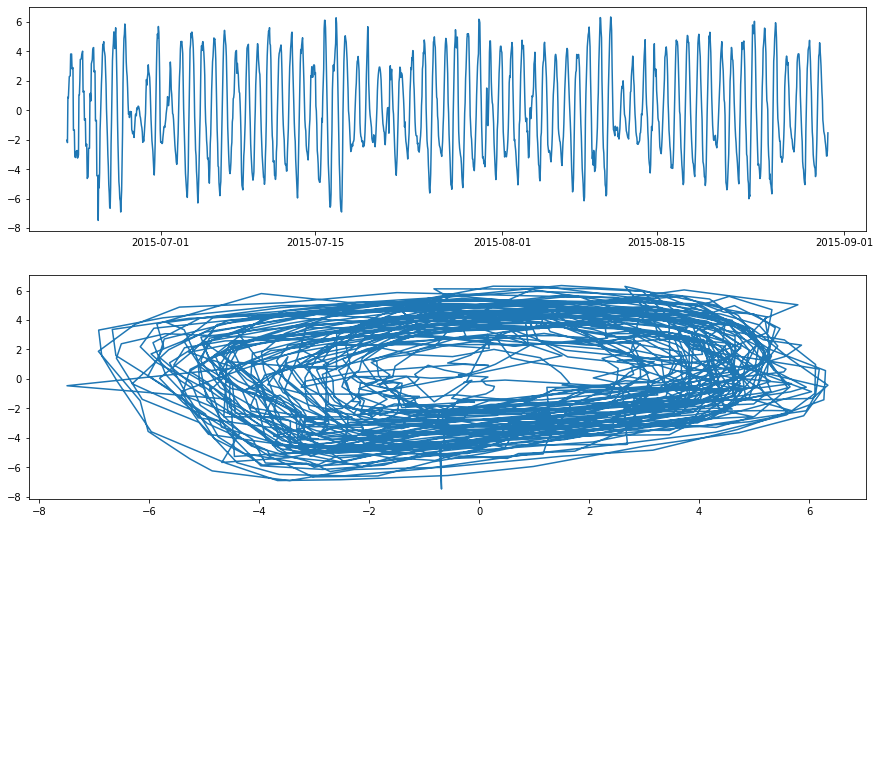

time: 485 ms (started: 2021-04-28 20:35:15 -04:00)


In [11]:
#plot the time-series and the embedded one 
fig, ax = plt.subplots(nrows=3,ncols=1,figsize=(15,14));
ax[0].plot(weatherDataMontreal);
ax[1].plot(embeddedWeather[0,:],embeddedWeather[1,:]);
ax[2].axis('off')

In [12]:
#embed into three dimensions
embeddedWeather3 = takensEmbedding(weatherDataMontreal, 6,3);

time: 0 ns (started: 2021-04-28 20:35:16 -04:00)


In [13]:
#plot the 3D embedding
ax = fig.add_subplot(3, 1, 3, projection='3d')
ax.plot(embeddedWeather3[0,:],embeddedWeather3[1,:],embeddedWeather3[2,:])
plt.show()

time: 62 ms (started: 2021-04-28 20:35:16 -04:00)


### Mutual information
But... How do know how to choose the delay and the embedding dimension? Well, that's a bit tricky and we do not know this a priori.  Considering the two embedding plots the three-dimensional one  looks more deterministic. But can we formalize this? Indeed  the answer is yes! There are two measures which give insight into which delay and which dimension to choose. The first one is the mutual information which is calculated as follows. First one calculates the minimium $x_{min}$  and maximum $x_{max}$ of the time-series. Then the interval $[x_{min}, x_{max}]$ is divided into a large number of bins. Denote by $P_k$ the probability that an element of the time-series is in the $k$th bin and by $P_{h,k}(\tau)$ the probability that $x_i$ is in the $h$th bin while $x_{i+\tau}$ is in the $k$th bin. Then the mutual information is
$$ I(\tau) = - \sum_{h=1}^{nBins} \sum_{k=1}^{nBins} P_{h,k}(\tau) \log \frac{P_{h,k}(\tau)}{P_h P_k}.$$
The first minimum of $I(\tau)$ as a function of $\tau$ gives the optimal delay, since there we get largest information by adding $x_{i+\tau}$. All probabilities here are calculated as empirical probabilities. 

In [14]:
def mutualInformation(data, delay, nBins):
    "This function calculates the mutual information given the delay"
    I = 0;
    xmax = max(data);
    xmin = min(data);
    delayData = data[delay:len(data)];
    shortData = data[0:len(data)-delay];
    sizeBin = abs(xmax - xmin) / nBins;
    #the use of dictionaries makes the process a bit faster
    probInBin = {};
    conditionBin = {};
    conditionDelayBin = {};
    for h in range(0,nBins):
        if h not in probInBin:
            conditionBin.update({h : (shortData >= (xmin + h*sizeBin)) & (shortData < (xmin + (h+1)*sizeBin))})
            probInBin.update({h : len(shortData[conditionBin[h]]) / len(shortData)});
        for k in range(0,nBins):
            if k not in probInBin:
                conditionBin.update({k : (shortData >= (xmin + k*sizeBin)) & (shortData < (xmin + (k+1)*sizeBin))});
                probInBin.update({k : len(shortData[conditionBin[k]]) / len(shortData)});
            if k not in conditionDelayBin:
                conditionDelayBin.update({k : (delayData >= (xmin + k*sizeBin)) & (delayData < (xmin + (k+1)*sizeBin))});
            Phk = len(shortData[conditionBin[h] & conditionDelayBin[k]]) / len(shortData);
            if Phk != 0 and probInBin[h] != 0 and probInBin[k] != 0:
                I -= Phk * math.log( Phk / (probInBin[h] * probInBin[k]));
    return I;

time: 0 ns (started: 2021-04-28 20:35:16 -04:00)


Now we calculate the mutual information for the weather data in dependendance of $\tau$, display it and calculate its first minimum. This then gives us the optimal embedding delay. Note that this needs approx 20 seconds. The number of bins is choosen to be 16 since we have ~1600 data points, so we can expect to have around 100 points in each bin.

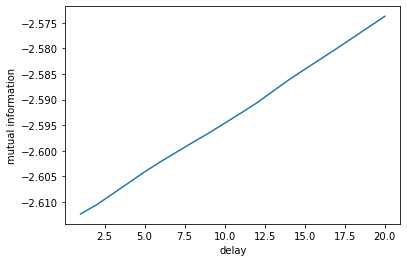

time: 9.11 s (started: 2021-04-28 20:35:16 -04:00)


In [15]:
datDelayInformation = []
for i in range(1,21):
    datDelayInformation = np.append(datDelayInformation,[mutualInformation(weatherDataMontreal,i,16)])
plt.plot(range(1,21),datDelayInformation);
plt.xlabel('delay');
plt.ylabel('mutual information');

Since the mutual information is increasing, the optimal delay seems to be 1. Note that this plot will look rather different for data sampled with higher frequency or with more data points. And indeed the attractor looks better:

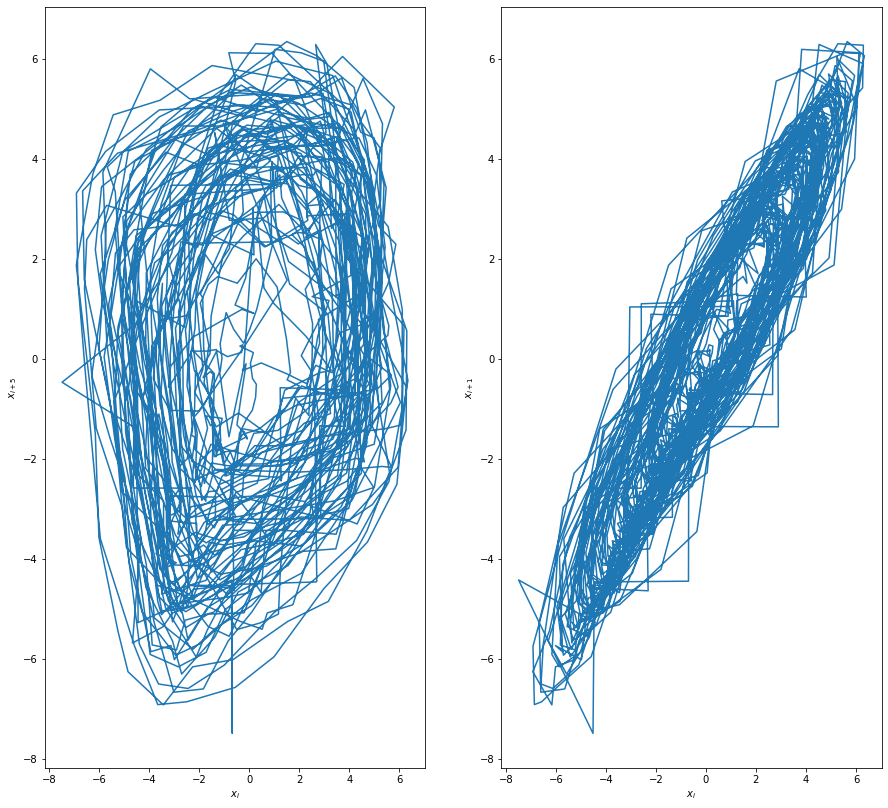

time: 766 ms (started: 2021-04-28 20:35:25 -04:00)


In [16]:
#embedd into two dimensions
embeddedWeather = takensEmbedding(weatherDataMontreal,5,2);
#plot the time-series and the embedded one 
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(15,14));
ax[0].plot(embeddedWeather[0,:],embeddedWeather[1,:]);
ax[0].set_xlabel('$x_i$');
ax[0].set_ylabel('$x_{i+5}$');
#now with delay=1
embeddedWeather = takensEmbedding(weatherDataMontreal,1,2);
ax[1].plot(embeddedWeather[0,:],embeddedWeather[1,:]);
ax[1].set_xlabel('$x_i$');
ax[1].set_ylabel('$x_{i+1}$');

### False nearest neighbours
We now explain the measure for determining the correct embedding dimension.  The measure used here is called false nearest neighbours and relies on the assumption that unfolding, i.e. embedding it in subsequently higher dimensions, a deterministic system is smooth. That is, points which are close in one embedding dimension should be close in the next higher embedding dimension. So if we have a point $p_i$ with neighbour $p_j$, i.e. $|| p_i - p_j || < \epsilon$ for some $\epsilon > 0$ then we look if the normalized distance $R_i$ for the next dimension, i.e. next coordinate, is greater than the threeshold $R_{tr} = 10$:
$$ R_i = \frac{| x_{i+m\tau} - x_{j + m \tau}|}{|| p_i - p_j ||} > R_{tr}.$$
If this is cased we have false nearest neighbour. The correct embedding dimension is achieved if the number of false nearest neighbours is very small. 


In [17]:
def false_nearest_neighours(data,delay,embeddingDimension):
    "Calculates the number of false nearest neighbours of embedding dimension"    
    embeddedData = takensEmbedding(data,delay,embeddingDimension);
    #the first nearest neighbour is the data point itself, so we choose the second one
    nbrs = NearestNeighbors(n_neighbors=2, algorithm='auto').fit(embeddedData.transpose())
    distances, indices = nbrs.kneighbors(embeddedData.transpose())
    #two data points are nearest neighbours if their distance is smaller than the standard deviation
    epsilon = np.std(distances.flatten())
    nFalseNN = 0
    for i in range(0, len(data)-delay*(embeddingDimension+1)):
        if (0 < distances[i,1]) and (distances[i,1] < epsilon) and ( (abs(data[i+embeddingDimension*delay] - data[indices[i,1]+embeddingDimension*delay]) / distances[i,1]) > 10):
            nFalseNN += 1;
    return nFalseNN

time: 0 ns (started: 2021-04-28 20:35:26 -04:00)


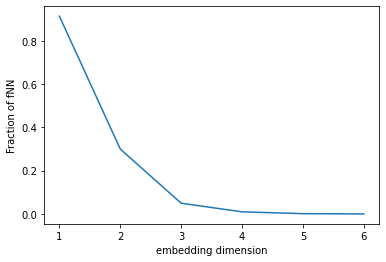

time: 313 ms (started: 2021-04-28 20:35:26 -04:00)


In [18]:
nFNN = []
for i in range(1,7):
    nFNN.append(false_nearest_neighours(weatherDataMontreal,1,i) / len(weatherDataMontreal))
plt.plot(range(1,7),nFNN);
plt.xlabel('embedding dimension');
plt.ylabel('Fraction of fNN');

The plot shows that the fraction of false nearest neighbours drops to zero with embedding dimension 4. This means that we could model the data with a system with four state variables.  To get a visualization of the embedded data we plot all 4 time series as well as create 3D plots with one dimension skipped.

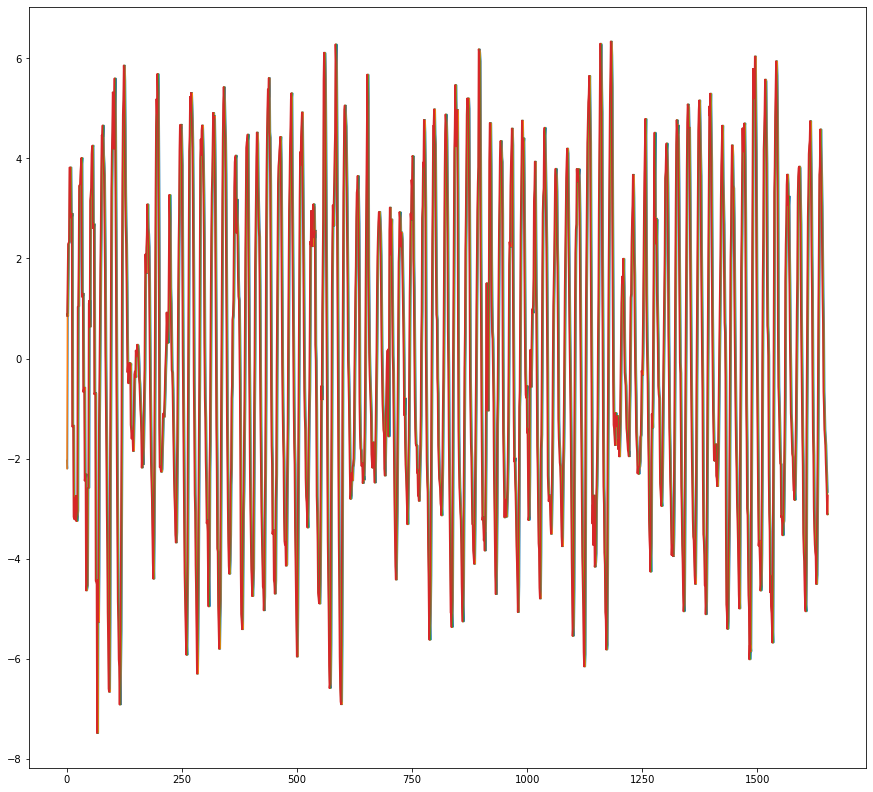

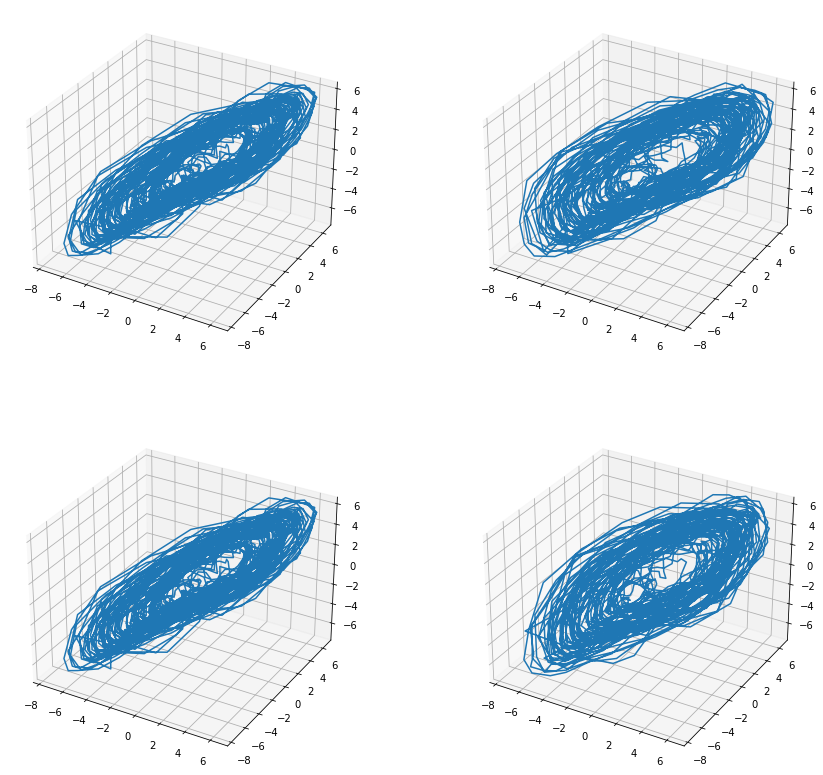

time: 985 ms (started: 2021-04-28 20:35:26 -04:00)


In [19]:
embeddedWeatherFinal =  takensEmbedding(weatherDataMontreal,1,4)
plt.figure(figsize=(15,14))
for i in range(0,4):
    plt.plot(embeddedWeatherFinal[i,:])
fig = plt.figure(figsize=(15,14))
ax = fig.add_subplot(2, 2, 1, projection='3d')
ax.plot(embeddedWeatherFinal[0,:],embeddedWeatherFinal[1,:],embeddedWeatherFinal[2,:]);
ax = fig.add_subplot(2, 2, 2, projection='3d')
ax.plot(embeddedWeatherFinal[0,:],embeddedWeatherFinal[1,:],embeddedWeatherFinal[3,:]);
ax = fig.add_subplot(2, 2, 3, projection='3d')
ax.plot(embeddedWeatherFinal[1,:],embeddedWeatherFinal[2,:],embeddedWeatherFinal[3,:]);
ax = fig.add_subplot(2, 2, 4, projection='3d')
ax.plot(embeddedWeatherFinal[0,:],embeddedWeatherFinal[2,:],embeddedWeatherFinal[3,:]);